In [1]:
from paths import *
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble= r'\usepackage{amsfonts}')

In [2]:
# for c in all_parsed_pdb_ids[list(parsed_and_found)[0]]:
#     print(c.attrib)
nrscc = pd.read_pickle(nrscc_path)
dccc = pd.read_pickle(commercial_conditions_path)
chems_pdb = pd.read_pickle(chems_table_from_pdb_path)
chems_dccc = pd.read_pickle(chems_table_from_commercial_screens_path)
pdb_dates = pd.read_pickle(pdb_dates_path)
pdb_conditions = pd.read_pickle(pdb_conditions_path)
dupes = pd.read_pickle(pdb_duplicates_lookup_path)
nrscc_clusters = pd.read_pickle(nrscc_clusters_path)

all_dupes = dupes.copy()
for v in dupes.values():
    all_dupes[v] = v

def resolve_dupes(cond):
    new_cond = []
    for f in cond:
        if f in all_dupes: 
            new_cond.append(all_dupes[f])
        else:
            new_cond.append(f)
    return tuple(sorted(new_cond))

nrscc_all = []
for cluster in nrscc:
    for cond in cluster:
        nrscc_all.append(tuple(sorted(cond)))
        
clusters = {}
for i in range(len(nrscc)):
    cluster = nrscc[i]
    for cond in cluster:
        clusters.setdefault(resolve_dupes(cond), set()).add(i)

linking_table = pd.read_pickle(pdb_commercial_linking_table_path)
np_linking_table = linking_table.to_numpy()
pdb_to_commercial = -1*np.ones(np.max(np_linking_table[:,1])+1, dtype=int)
pdb_to_commercial[np_linking_table[:,1]] = np_linking_table[:,0]
commercial_to_pdb = -1*np.ones(np.max(np_linking_table[:,0])+1, dtype=int)
commercial_to_pdb[np_linking_table[:,0]] = np_linking_table[:,1]

nrscc_filtered = []

# Remove any conditions that are
# -> only composed of a buffer
# -> only one factor with concentration < 0.1 M
# Also, filter by in DCCC
for cond in nrscc_all:
    if -1 in pdb_to_commercial[list(cond)]: # Note: doing this makes no difference, as expected :)
        continue
    if len(cond) == 1:
        details = chems_pdb.iloc[cond[0]]
        if details["buffer"] == "Buffer" or details["molarity"] <= 0.1:
            continue
    nrscc_filtered.append(cond)

c = Counter(nrscc_filtered)
nrscc_sorted = sorted(c, key=lambda x:c[x], reverse=True)

In [3]:
num_conditions_in_nrscc = 0
num_factors_in_nrscc = 0
for cluster in nrscc:
    for condition in cluster:
        num_conditions_in_nrscc += 1
        num_factors_in_nrscc += len(condition)

print(f"#conditions in nrscc = {num_conditions_in_nrscc}")
print(f"   #factors in nrscc = {num_factors_in_nrscc}")

#conditions in nrscc = 79917
   #factors in nrscc = 230672


In [4]:
# number of conditions in NRSCC [x]
# number of conditions in DCCC  [ ]
# chemicals in NRSCC ranked     [x]
# how many conditions in D-CCC map onto NR-SCC
# how many conditions in NR-SCC map onto D-CCC

In [5]:
print(f"Number of conditions in NRSCC = {sum([len(x) for x in nrscc])}")
print(f"Number of clusters in NRSCC = {len(nrscc)}")

Number of conditions in NRSCC = 79917
Number of clusters in NRSCC = 49250


In [6]:
nrscc_all = []
for x in nrscc:
    for y in x:
        nrscc_all.extend(y)

In [7]:
dccc_conds = set()
for screen in dccc:
    for condition in dccc[screen]:
        dccc_conds.add(tuple(sorted(condition)))
all_dccc_chems = []
for cond in dccc_conds:
    all_dccc_chems.extend(cond)

In [8]:
len(dccc_conds)

12484

In [9]:
t1 = chems_pdb.where(chems_pdb["buffer"]=="Buffer")["name"].iloc[nrscc_all].value_counts()[:10]
t2 = chems_dccc.where(chems_dccc["buffer"]=="Buffer")["name"].iloc[all_dccc_chems].value_counts()[:10]
table = pd.DataFrame()
table["NRSCC"] = t1.index
table["BufferCountNRSCC"] = t1.values
table["DCCC"] = t2.index
table["BufferCountDCCC"] = t2.values
print(table.to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
                     NRSCC &  BufferCountNRSCC &                       DCCC &  BufferCountDCCC \\
\midrule
             tris chloride &             11531 &               sodium hepes &             1438 \\
              sodium hepes &             11307 &              tris chloride &             1390 \\
                sodium mes &              6410 &                 sodium mes &             1007 \\
            sodium acetate &              5704 &             sodium acetate &              951 \\
         bis-tris chloride &              4467 &          trisodium citrate &              709 \\
         trisodium citrate &              3962 &          sodium cacodylate &              483 \\
         sodium cacodylate &              3141 &          bis-tris chloride &              328 \\
 bis-tris propane chloride &              1711 &  bis-tris propane chloride &              310 \\
                 imidazole &              1205 &                  imidazole & 

In [10]:
print(chems_pdb.iloc[:2:5].to_latex())

\begin{tabular}{llrlrrrll}
\toprule
{} &                   name &  conc & units &  ph &  percentage concentration &  molarity &                ions &     buffer \\
\midrule
0 &  potassium thiocyanate &   0.1 &     m & NaN &                   0.09718 &       0.1 &  [(1, 21), (1, 14)] &  NotBuffer \\
\bottomrule
\end{tabular}



In [11]:
t1 = chems_pdb.where(chems_pdb["buffer"]=="NotBuffer")["name"].iloc[nrscc_all].value_counts()[:10]
t2 = chems_dccc.where(chems_dccc["buffer"]=="NotBuffer")["name"].iloc[all_dccc_chems].value_counts()[:10]
table = pd.DataFrame()
table["NRSCC"] = t1.index
table["NotBufferCountNRSCC"] = t1.values
table["DCCC"] = t2.index
table["NotBufferCountDCCC"] = t2.values
print(table.to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
                    NRSCC &  NotBufferCountNRSCC &                      DCCC &  NotBufferCountDCCC \\
\midrule
 polyethylene glycol 3350 &                19320 &  polyethylene glycol 4000 &                1207 \\
         ammonium sulfate &                14063 &           sodium chloride &                1199 \\
          sodium chloride &                10124 &          ammonium sulfate &                1010 \\
 polyethylene glycol 4000 &                 9692 &   polyethylene glycol 400 &                 935 \\
 polyethylene glycol 8000 &                 7424 &        magnesium chloride &                 789 \\
       magnesium chloride &                 7305 &  polyethylene glycol 3350 &                 783 \\
                 glycerol &                 6320 &  polyethylene glycol 8000 &                 755 \\
          lithium sulfate &                 4217 &  2-methyl-2,4-pentanediol &                 738 \\
  polyethylene glycol 400 &               

In [12]:
# percent of conditions vs number of factors
counts_nrscc = {}
for cluster in nrscc:
    for condition in cluster:
        counts_nrscc[len(condition)] = counts_nrscc.setdefault(len(condition), 0) + 1
counts_dccc = {}
for condition in dccc_conds:
    counts_dccc[len(condition)] = counts_dccc.setdefault(len(condition), 0) + 1

In [13]:
def linewidth_from_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.

    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.

    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()
    if reference == 'x':
        length = fig.bbox_inches.width * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())
    # Convert length to points
    length *= 72
    # Scale linewidth to value range
    return linewidth * (length / value_range)

In [14]:
counts_nrscc

{3: 31495,
 2: 26116,
 1: 6116,
 4: 9816,
 5: 3125,
 6: 1567,
 7: 829,
 8: 437,
 11: 53,
 10: 110,
 12: 25,
 9: 191,
 21: 2,
 13: 15,
 14: 7,
 16: 3,
 17: 3,
 15: 5,
 18: 1,
 20: 1}

[10.97704918]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


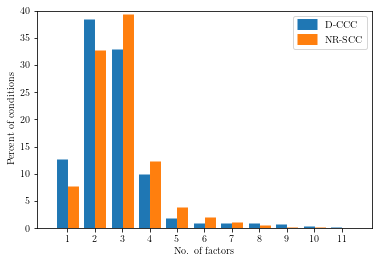

In [15]:
nrscc_vals = np.asarray(list(counts_nrscc.values()))
dccc_vals = np.asarray(list(counts_dccc.values()))
fig, ax = plt.subplots()
plt.xlim(-0.1, 12.1)
lw = linewidth_from_data_units(0.4, ax, reference='x')
print(lw)
plt.vlines(np.asarray(list(counts_dccc.keys()))-0.2, 0, 100*dccc_vals/np.sum(dccc_vals), color='tab:blue', linewidth=lw, label="D-CCC")
plt.vlines(np.asarray(list(counts_nrscc.keys()))+0.2, 0, 100*nrscc_vals/np.sum(nrscc_vals), color='tab:orange', linewidth=lw, label="NR-SCC")
plt.xticks(np.arange(1, 12), np.arange(1, 12))
plt.ylim(0, 40)
plt.ylabel("Percent of conditions")
plt.xlabel("No. of factors")
plt.legend()
plt.savefig("generated/histfactors.pdf", dpi=90)
plt.show()

[10.14545455]


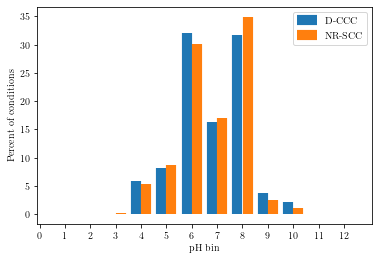

In [16]:
ph_nrscc = chems_pdb.iloc[nrscc_all].ph.dropna().values
ph_dccc = chems_dccc.iloc[all_dccc_chems].ph.dropna().values
ph_nrscc, counts_nrscc = np.unique(np.round(ph_nrscc[ph_nrscc < 14]), return_counts=True)
ph_dccc, counts_dccc = np.unique(np.round(ph_dccc[ph_dccc < 14]), return_counts=True)
fig, ax = plt.subplots()
plt.xlim(-0.1, 13.1)
lw = linewidth_from_data_units(0.4, ax, reference='x')
print(lw)
plt.vlines(ph_dccc-0.2, 0, 100*counts_dccc/np.sum(counts_dccc), linewidth=lw, color="tab:blue", label="D-CCC")
plt.vlines(ph_nrscc+0.2, 0, 100*counts_nrscc/np.sum(counts_nrscc), linewidth=lw, color="tab:orange", label="NR-SCC")
plt.legend()
plt.xlabel("pH bin")
plt.ylabel("Percent of conditions")
plt.xticks(np.arange(13), np.arange(13))
plt.savefig("generated/pHhist.pdf", dpi=90)
plt.show()

In [17]:
# Load screens
sgD = {}
for i in range(1, 6):
    sgD[f"0.{i}"] = np.load(f"generated/screen/Shotgun_II_Greedy_0.{i}.npy", allow_pickle=True)
sgGreedy = np.load("generated/screen/Shotgun_II_Greedy.npy", allow_pickle=True)

In [18]:
def ranks(screen):
    out = []
    for cond in screen:
        out.append(len(set(clusters[cond])))
    return out

In [19]:
sorted(ranks(sgD['0.2']), reverse=True)[-1]

28

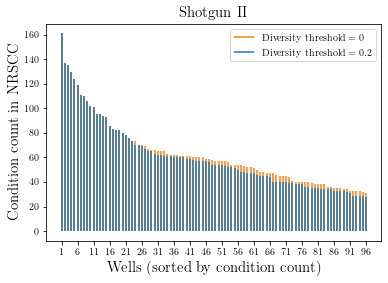

In [27]:
fig, ax = plt.subplots()
plt.vlines(range(96), 0, sorted(ranks(sgGreedy), reverse=True), colors="tab:orange")
plt.vlines(range(96), 0, sorted(ranks(sgD['0.2']), reverse=True), colors="tab:blue")
plt.xlabel("Wells (sorted by condition count)", fontsize=15)
plt.xticks(np.arange(0, 97, 5), 1+np.arange(0, 97, 5))
plt.ylabel("Condition count in NRSCC", fontsize=15)
plt.title("Shotgun II", fontsize=15)
plt.legend(["Diversity threshold = 0", "Diversity threshold = 0.2"])
plt.savefig("generated/screen/SGII.pdf", transparent=False, dpi=90)

In [8]:
# Number of wells in the commercial screens
numWells = 0
for dirpath, dirnames, filenames in os.walk(commercial_screens_folder):
    for filename in [f for f in filenames if f.endswith(".xml")]:
        tree = ET.parse(os.path.join(dirpath, filename))
        root = tree.getroot()
        numWells += len(list(root.iter("well")))
print(numWells)

24303


In [9]:
# Total number of commercial screens
numScreens=0
for dirpath, dirnames, filenames in os.walk(commercial_screens_folder):
    for fname in filenames:
        numScreens += 1
print(numScreens)

347


In [10]:
chems_pdb.where(chems_pdb["buffer"]=="Buffer")["name"].iloc[nrscc_all].value_counts()[:10]

tris chloride                11531
sodium hepes                 11307
sodium mes                    6410
sodium acetate                5704
bis-tris chloride             4467
trisodium citrate             3962
sodium cacodylate             3141
bis-tris propane chloride     1711
imidazole                     1205
sodium bicine                  779
Name: name, dtype: int64

In [11]:
chems_pdb[(chems_pdb["buffer"]=="Buffer") & (chems_pdb["name"]=="sodium acetate")]

,name,conc,units,ph,percentage concentration,molarity,ions,buffer
10,sodium acetate,0.100,m,5.00,0.082020,0.100,"[(1, 57), (1, 25)]",Buffer
106,sodium acetate,0.050,m,4.00,0.041010,0.050,"[(1, 57), (1, 25)]",Buffer
167,sodium acetate,0.100,m,4.00,0.082020,0.100,"[(1, 57), (1, 25)]",Buffer
169,sodium acetate,0.100,m,4.20,0.082020,0.100,"[(1, 57), (1, 25)]",Buffer
187,sodium acetate,0.100,m,5.50,0.082020,0.100,"[(1, 57), (1, 25)]",Buffer
...,...,...,...,...,...,...,...,...
22747,sodium acetate,0.085,m,5.00,0.069717,0.085,"[(1, 57), (1, 25)]",Buffer
22799,sodium acetate,0.100,m,4.63,0.082020,0.100,"[(1, 57), (1, 25)]",Buffer
22861,sodium acetate,0.010,m,4.20,0.008202,0.010,"[(1, 57), (1, 25)]",Buffer
23004,sodium acetate,0.060,m,5.60,0.049212,0.060,"[(1, 57), (1, 25)]",Buffer


In [12]:
chems_pdb[chems_pdb["name"]=="sodium acetate"]

,name,conc,units,ph,percentage concentration,molarity,ions,buffer
10,sodium acetate,0.100,m,5.00,0.082020,0.100,"[(1, 57), (1, 25)]",Buffer
100,sodium acetate,0.200,m,NaN,0.164040,0.200,"[(1, 57), (1, 25)]",NotBuffer
106,sodium acetate,0.050,m,4.00,0.041010,0.050,"[(1, 57), (1, 25)]",Buffer
165,sodium acetate,1.600,m,NaN,1.312320,1.600,"[(1, 57), (1, 25)]",NotBuffer
167,sodium acetate,0.100,m,4.00,0.082020,0.100,"[(1, 57), (1, 25)]",Buffer
...,...,...,...,...,...,...,...,...
22799,sodium acetate,0.100,m,4.63,0.082020,0.100,"[(1, 57), (1, 25)]",Buffer
22861,sodium acetate,0.010,m,4.20,0.008202,0.010,"[(1, 57), (1, 25)]",Buffer
22891,sodium acetate,2.700,m,7.20,2.214540,2.700,"[(1, 57), (1, 25)]",NotBuffer
23004,sodium acetate,0.060,m,5.60,0.049212,0.060,"[(1, 57), (1, 25)]",Buffer


In [13]:
pkas_table = pd.read_pickle(chems_info_table_path)

In [14]:
pkas_table[pkas_table["name"]=="sodium acetate"]

,name,pka1,pka2,pka3,mw,solubility,density
886,sodium acetate,4.76,None,None,82.03,46.5,None


In [15]:
_buffer_class = "NotBuffer"
pkas = pkas_table[pkas_table["name"] == "sodium acetate"]
for pka in ["pka1", "pka2", "pka3"]:
    if pd.notna(pkas[pka]).all():
        if abs(pkas[pka]-5).all() < 1:
            _buffer_class = "Buffer"

In [16]:
_buffer_class

'Buffer'

In [17]:
abs(pkas[pka]-5).all()

True

In [18]:
chems_pdb.iloc[10]

name                            sodium acetate
conc                                       0.1
units                                        m
ph                                           5
percentage concentration               0.08202
molarity                                   0.1
ions                        [(1, 57), (1, 25)]
buffer                                  Buffer
Name: 10, dtype: object

In [19]:
chems_pdb[chems_pdb["name"]=="trisodium citrate"]

,name,conc,units,ph,percentage concentration,molarity,ions,buffer
23,trisodium citrate,0.100,m,5.4,0.258060,0.100,"[(3, 57), (1, 46)]",Buffer
50,trisodium citrate,0.100,m,NaN,0.258060,0.100,"[(3, 57), (1, 46)]",NotBuffer
61,trisodium citrate,0.010,m,NaN,0.025806,0.010,"[(3, 57), (1, 46)]",NotBuffer
63,trisodium citrate,0.100,m,5.6,0.258060,0.100,"[(3, 57), (1, 46)]",Buffer
71,trisodium citrate,0.100,m,5.5,0.258060,0.100,"[(3, 57), (1, 46)]",Buffer
...,...,...,...,...,...,...,...,...
22958,trisodium citrate,0.033,m,5.6,0.085160,0.033,"[(3, 57), (1, 46)]",Buffer
22972,trisodium citrate,0.092,m,2.2,0.237415,0.092,"[(3, 57), (1, 46)]",Buffer
22983,trisodium citrate,0.020,m,4.0,0.051612,0.020,"[(3, 57), (1, 46)]",Buffer
23007,trisodium citrate,0.222,m,6.3,0.572893,0.222,"[(3, 57), (1, 46)]",Buffer


In [20]:
pkas_table = pd.read_pickle(chems_info_table_path)

In [21]:
row = chems_pdb[chems_pdb["name"]=="trisodium citrate"].iloc[0]
_buffer_class = "NotBuffer"
if row["ph"] != None:
    pkas = pkas_table[pkas_table["name"] == row["name"]]
    for pka in ["pka1", "pka2", "pka3"]:
        if pd.notna(pkas[pka]).all():
            if abs(pkas[pka]-row["ph"]).all() < 1:
                _buffer_class = "Buffer"
print(row)
print(pkas)
print(_buffer_class)

name                         trisodium citrate
conc                                       0.1
units                                        m
ph                                         5.4
percentage concentration               0.25806
molarity                                   0.1
ions                        [(3, 57), (1, 46)]
buffer                                  Buffer
Name: 23, dtype: object
                   name  pka1  pka2 pka3      mw solubility density
1059  trisodium citrate  3.13  4.74  6.4  258.06         63    None
Buffer


In [11]:
linking_table = pd.read_pickle(pdb_commercial_linking_table_path)
np_linking_table = linking_table.to_numpy()
pdb = pd.read_pickle(pdb_conditions_path)
dccc = pd.read_pickle(commercial_conditions_path)

In [12]:
# np_linking_table[:,0] commercial
# np_linking_table[:,1] pdb
pdb_to_commercial = -1*np.ones(np.max(np_linking_table[:,1])+1, dtype=int)
pdb_to_commercial[np_linking_table[:,1]] = np_linking_table[:,0]
commercial_to_pdb = -1*np.ones(np.max(np_linking_table[:,0])+1, dtype=int)
commercial_to_pdb[np_linking_table[:,0]] = np_linking_table[:,1]

In [13]:
all_dccc_conds = []
for screen in dccc:
    all_dccc_conds.extend(dccc[screen])

all_pdb_conds = []
for entry in pdb:
    all_pdb_conds.append(pdb[entry])

all_nrscc_conds = []
for cluster in nrscc:
    all_nrscc_conds.extend(cluster)

# hash for fast lookups
all_dccc_conds_hashed = set([frozenset(sorted(x)) for x in all_dccc_conds])
all_nrscc_conds_hashed = set([frozenset(sorted(x)) for x in all_nrscc_conds])
all_pdb_conds_hashed = set([frozenset(sorted(x)) for x in all_pdb_conds])

In [14]:
nrscc_in_dccc = 0
for x in all_nrscc_conds:
    cond = frozenset(sorted(pdb_to_commercial[list(x)]))
    nrscc_in_dccc += cond in all_dccc_conds_hashed
print(nrscc_in_dccc)

16889


In [15]:
pdb_in_dccc = 0
for x in all_pdb_conds:
    try:
        cond = frozenset(sorted(pdb_to_commercial[list(x)]))
        pdb_in_dccc += cond in all_dccc_conds_hashed
    except IndexError:
        continue
print(pdb_in_dccc)

21170


In [16]:
in_pdb_not_nrscc = []
for x in all_dccc_conds:
    try:
        cond = frozenset(sorted(commercial_to_pdb[list(x)]))
        if cond in all_pdb_conds_hashed and cond not in all_nrscc_conds_hashed:
            in_pdb_not_nrscc.append(cond)
    except IndexError:
        continue

In [23]:
in_pdb_not_nrscc[0]

frozenset({58, 317, 429})

In [27]:
dccc_in_nrscc = 0
for x in all_dccc_conds:
    try:
        cond = frozenset(sorted(commercial_to_pdb[list(x)]))
        dccc_in_nrscc += cond in all_nrscc_conds_hashed
    except IndexError:
        continue
print(dccc_in_nrscc)

8501


In [28]:
dccc_in_pdb = 0
for x in all_dccc_conds:
    try:
        cond = frozenset(sorted(commercial_to_pdb[list(x)]))
        dccc_in_pdb += cond in all_pdb_conds_hashed
    except IndexError:
        continue
print(dccc_in_pdb)

8959


In [29]:
screen00, counts00 = np.load("generated/screen/screen_counts_0.0.npy", allow_pickle=True)
screen02, counts02 = np.load("generated/screen/screen_counts_0.2.npy", allow_pickle=True)

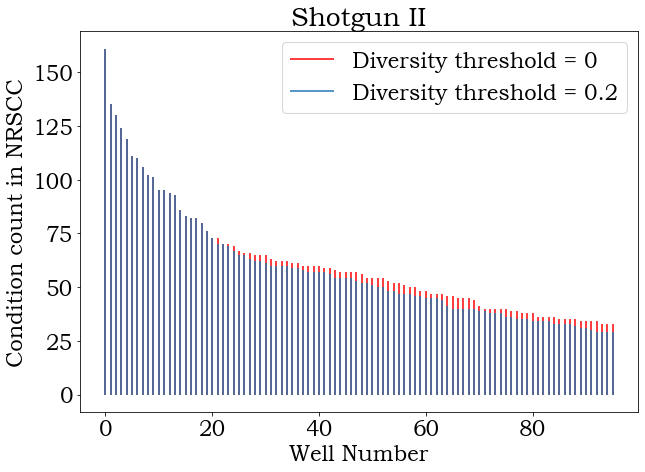

In [30]:
font = {'family' : 'Bookman Old Style',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
plt.vlines(range(96), 0, counts00, colors="r")
plt.vlines(range(96), 0, counts02)
plt.xlabel("Well Number")
plt.ylabel("Condition count in NRSCC")
plt.title("Shotgun II")
plt.legend(["Diversity threshold = 0", "Diversity threshold = 0.2"])
plt.savefig("generated/screen/SGII.png", transparent=False)

In [31]:
cutoffs, totalhits = np.load("generated/cutoffs_totalhits.npy", allow_pickle=True)

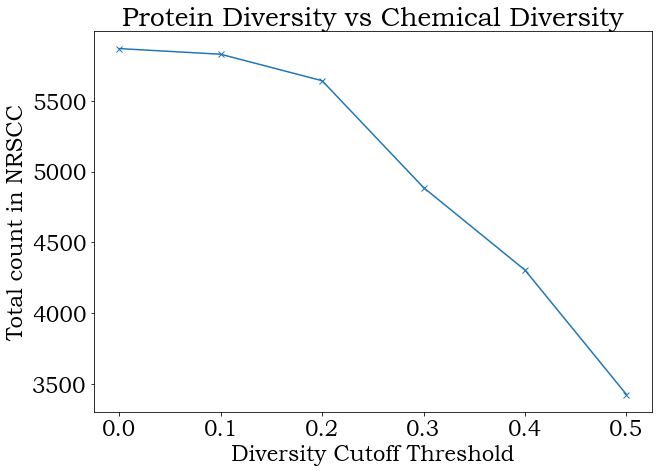

In [34]:
plt.figure(figsize=(10,7))
plt.plot(cutoffs, totalhits, 'x-')
plt.xlabel("Diversity Cutoff Threshold")
plt.ylabel("Total count in NRSCC")
plt.title("Protein Diversity vs Chemical Diversity")
plt.savefig("generated/screen/CutoffsHitcounts.png")

In [38]:
pdb_dates_dict = {}
for entry in pdb_dates:
    pdb_dates_dict[entry[0]] = entry[1]

In [33]:
upto_date = 20140510 # 10 May 2014
pdb_in_dccc_2014 = 0
for pdb_id in pdb:
    if pdb_dates_dict[pdb_id] <= upto_date:
        x = pdb[pdb_id]
        try:
            cond = frozenset(sorted(pdb_to_commercial[list(x)]))
            pdb_in_dccc_2014 += cond in all_dccc_conds_hashed
        except IndexError:
            continue
print(pdb_in_dccc_2014)

NameError: name 'pdb_dates_dict' is not defined

In [ ]:
################################################

In [8]:
pdb_conditions = pd.read_pickle(pdb_conditions_path)
dupes = pd.read_pickle(pdb_duplicates_lookup_path)
nrscc_clusters = pd.read_pickle(nrscc_clusters_path)

all_dupes = dupes.copy()
for v in dupes.values():
    all_dupes[v] = v
def resolve_dupes(cond):
    new_cond = []
    for f in cond:
        if f in all_dupes: 
            new_cond.append(all_dupes[f])
        else:
            new_cond.append(f)
    return tuple(sorted(new_cond))

In [46]:
all_nrscc_ids = set()
for cluster in nrscc_clusters:
    for pdbid in cluster:
        all_nrscc_ids.add(pdbid.lower())

In [49]:
ids_by_cond = {}
for k in pdb_conditions:
    if k not in all_nrscc_ids: continue
    cond = pdb_conditions[k]
    for i in range(len(cond)):
        if cond[i] in dupes: cond[i] = dupes[cond[i]]
    ids_by_cond.setdefault(tuple(sorted(cond)), []).append(k)

In [50]:
len(ids_by_cond)

56812

In [51]:
conds_sorted_by_ids = sorted(ids_by_cond, key=lambda x:len(ids_by_cond[x]), reverse=True)

In [52]:
len(ids_by_cond[conds_sorted_by_ids[0]])

367

In [53]:
from collections import Counter

In [54]:
nrscc_all = []
for cluster in nrscc:
    for cond in cluster:
        nrscc_all.append(tuple(sorted(cond)))

In [55]:
c = Counter(nrscc_all)
nrscc_sorted = sorted(c, key=lambda x:c[x], reverse=True)

In [56]:
chems_pdb.iloc[list(nrscc_sorted[0])]

,name,conc,units,ph,percentage concentration,molarity,ions,buffer
89,tris chloride,0.1,m,8.5,0.15760,0.10,"[(1, 55)]",Buffer
303,polyethylene glycol 4000,30.0,w/v,NaN,30.00000,0.75,[],NotBuffer
304,magnesium chloride,0.2,m,NaN,0.19044,0.20,"[(1, 39), (1, 55)]",NotBuffer


In [57]:
p = []
for i in range(96):
    cond = nrscc_sorted[i]
    p.extend(ids_by_cond[cond])

In [60]:
clusters = {}
for i in range(len(nrscc_clusters)):
    for pdb_id in nrscc_clusters[i]:
        clusters[pdb_id.lower()] = i

In [61]:
c = []
for pdbid in p:
    c.append(clusters[pdbid])

In [63]:
len(c)

7549

In [64]:
len(set(c)) # what is this for SG II 0.2 ??

5500

In [103]:
clusters2 = {}
for i in range(len(nrscc)):
    cluster = nrscc[i]
    for cond in cluster:
        clusters2.setdefault(resolve_dupes(cond), []).append(i)

In [104]:
c2 = []
for i in range(96):
    cond = nrscc_sorted[i]
    c2.extend(clusters2[cond])

In [105]:
len(c2)

6101

In [106]:
len(set(c2))

5500

In [125]:
clusters_by_condition = {}
for cond in clusters2:
    clusts = clusters2[cond]
    for c in clusts:
        clusters_by_condition.setdefault(c, []).append(cond)

In [133]:
csorted = sorted(clusters_by_condition, key=lambda x:len(clusters_by_condition[x]), reverse=True)[:100]
len(clusters_by_condition[353])

234

In [146]:
csorted = sorted(nrscc, key=lambda x:len(x), reverse=True)

In [142]:
len(csorted[0])

234

In [149]:
idssorted = sorted(nrscc_clusters, key=lambda x:len(x), reverse=True)
len(idssorted[0])

937

In [150]:
len([x for x in nrscc if len(x) == 1])

38083

In [118]:
y = []
for i in range(96):
    cond = nrscc_sorted[i]
    y.append(len(clusters2[cond]))

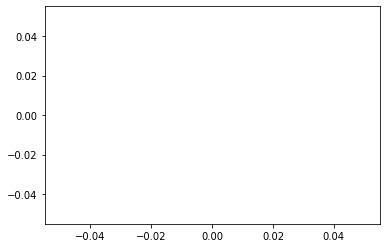

In [121]:
y = []
for i in range(96):
    try:
        cond = nrscc_sorted[i]
        y.append(len(clusters[cond]))
    except KeyError:
        continue
plt.plot(y)